# Breakout: Individual Project Code

## Google Drive Integration

Mount Google Drive.

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

## Setup

Import modules.

In [2]:
import gym
import numpy as np
import random
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.distributions import Categorical

import cv2

from collections import deque

from copy import deepcopy

Set device.

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('device: ', device)

device:  cpu


Set environment.

In [4]:
env = gym.make('Breakout-v0')

Set seed for reproducible environment and action spaces

In [5]:
seed = 742
torch.manual_seed(seed)
env.seed(seed)
random.seed(seed)
np.random.seed(seed)
env.action_space.seed(seed)

[742]

## Environment preview

In [6]:
def show_image(image, greyscale=False):
    """Displays image without grid lines."""
    if greyscale:
        plt.imshow(image, cmap=plt.get_cmap('gray'))    
    else:
        plt.imshow(image)
    plt.xticks([])
    plt.yticks([])

Show the initial state and print its shape.

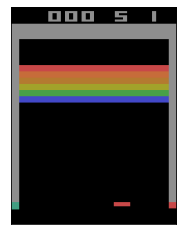

obervation space:  Box(210, 160, 3)
action space:  Discrete(4)
no. actions:  4


In [7]:
observation = env.reset()

show_image(observation)
plt.show()

print('obervation space: ', env.observation_space)
print('action space: ', env.action_space)
print('no. actions: ', env.action_space.n)

Take a random action, then make an observation.

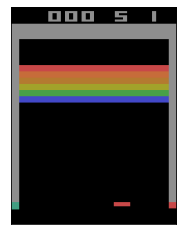

action: 0
reward: 0.0
done False
info {'ale.lives': 5}


In [8]:
random_action = env.action_space.sample()

next_observation, reward, done, info = env.step(random_action)

show_image(next_observation)
plt.show()

print('action:', random_action)
print('reward:', reward)
print('done', done)
print('info', info)

## Frame pre-processing

In [9]:
obs = env.reset()

### Greyscale

shape before:  (210, 160, 3)
shape after:   (210, 160)


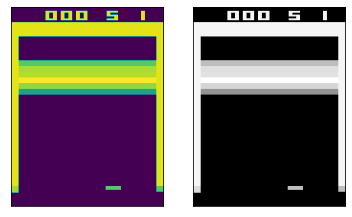

In [10]:
print("shape before: ", obs.shape)
gray_obs = cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY)
print("shape after:  ", gray_obs.shape)

plt.subplot(1, 2, 1)
show_image(gray_obs)
plt.subplot(1, 2, 2)
show_image(gray_obs, greyscale=True)
plt.show()

### Crop

shape before:  (210, 160)
shape after:   (160, 160)


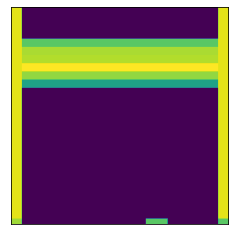

In [11]:
print('shape before: ', gray_obs.shape)
cropped_obs = gray_obs[33:193]
print('shape after:  ', cropped_obs.shape)

show_image(cropped_obs)

### Resize

shape before:  (160, 160)
shape after transformation:   (84, 84)


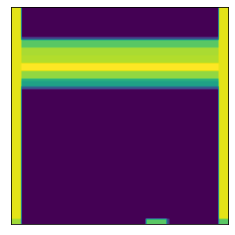

In [12]:
print("shape before: ", cropped_obs.shape)
resized_obs = cv2.resize(cropped_obs, (84, 84))
print("shape after transformation:  ", resized_obs.shape)

show_image(resized_obs)

### Pre-processing function

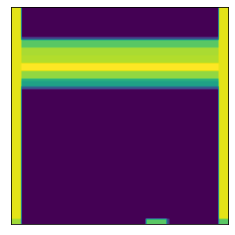

In [13]:
def preprocess(obs):
  gray_obs = cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY)
  cropped_obs = gray_obs[33:193]
  resized_obs = cv2.resize(cropped_obs, (84, 84))
  return resized_obs

show_image(preprocess(env.reset()))

View pre-processed next state, having taken a random action. 

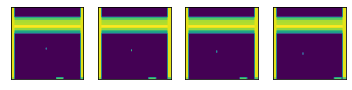

In [14]:
for i in range(4):
    rand_act = env.action_space.sample()
    obs = env.step(rand_act)[0]
    
    plt.subplot(1, 4, i+1)
    show_image(preprocess(obs))
plt.show()

## State buffer

In [15]:
def show_state(state):
    for i, frame in enumerate(state):
        plt.subplot(1, len(state), i+1)
        plt.imshow(frame, cmap=plt.get_cmap('gray'))
        plt.xticks([])
        plt.yticks([])

### Create state buffer to store 4 consecutive frames.

In [16]:
state = torch.zeros(4, 84, 84)

current state:


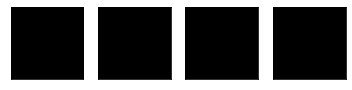

next state:


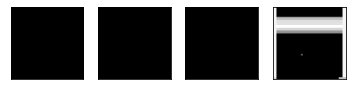

In [17]:
print('current state:')
show_state(state)
plt.show()

action = env.action_space.sample()
next_obs = preprocess(env.step(action)[0])

state = torch.roll(state, shifts=-1, dims=0)
state[-1] = torch.tensor(next_obs).unsqueeze(0)

print('next state:')
show_state(state)
plt.show()

## Model definition

### Define CNN layer.

In [18]:
cnn = nn.Sequential(
    nn.Conv2d(in_channels=4, out_channels=32, kernel_size=8, stride=4),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2),
    nn.ReLU(),
    nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
    nn.ReLU()
    )

cnn.to(device)

Sequential(
  (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
  (1): ReLU()
  (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
  (3): ReLU()
  (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (5): ReLU()
)

Feed state buffer stack through CNN layer.

In [19]:
cnn_out = cnn(state.unsqueeze(0))
print('shape of CNN output: ', cnn_out.shape)

shape of CNN output:  torch.Size([1, 64, 7, 7])


Flatten CNN layer output, and print.

In [20]:
fc_input_dim = cnn_out.flatten().shape[0]
print('fully connecetd layer input size: ', fc_input_dim)

fully connecetd layer input size:  3136


### Define fully-connected (fc) policy layer.

In [21]:
fc_pi = nn.Sequential(
    nn.Linear(fc_input_dim, 512),
    nn.ReLU(),
    nn.Linear(512, env.action_space.n)
    )

fc_pi.to(device)

Sequential(
  (0): Linear(in_features=3136, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=4, bias=True)
)

Reshape CNN layer output, then feed through fc layer.

In [22]:
shape_before = cnn_out.shape
print('shape before reshape: ', shape_before)
fc_input = cnn_out.reshape(-1, fc_input_dim)
print('shape after reshape:  ', fc_input.shape)

shape before reshape:  torch.Size([1, 64, 7, 7])
shape after reshape:   torch.Size([1, 3136])


View fc policy layer output.

In [23]:
fc_output = fc_pi(fc_input)
fc_output

tensor([[-0.1238, -0.1484,  0.3725,  0.0406]], grad_fn=<AddmmBackward>)

View fc layer output shape to obtain softmax dimension.

In [24]:
print(fc_output.shape)

torch.Size([1, 4])


We want the sum of action probabilities to equal 1. The porbabilities come from the values on the last axis (axis 1).

In [25]:
softmax_dim = 1

Obtain action probabilities from values.

In [26]:
prob = F.softmax(fc_output, dim=softmax_dim)
prob

tensor([[0.2085, 0.2034, 0.3424, 0.2457]], grad_fn=<SoftmaxBackward>)

Turn action probabilities into a categorical distribution.

> 'A categorical distribution is a discrete probability distribution that describes the possible results of a random variable that can take on one of K possible categories, with the probability of each category separately specified' &mdash; Wikipedia

In [27]:
m = Categorical(prob)
m

Categorical(probs: torch.Size([1, 4]))

Sample an action from the categorical distribution.

In [28]:
a = m.sample().item() # .item() converts it from tensor to int
a

0

### Define fully connected (fc) value layer.

In [29]:
fc_v = nn.Sequential(
    nn.Linear(fc_input_dim, 512),
    nn.ReLU(),
    nn.Linear(512, 1)
    )

fc_v.to(device)

Sequential(
  (0): Linear(in_features=3136, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=1, bias=True)
)

View fc value layer output.

In [30]:
fc_out = fc_v(fc_input)
fc_out

tensor([[0.4275]], grad_fn=<AddmmBackward>)

### Define functions

Define a function to pass a state buffer stack through the network and obtain action probabilities.

In [31]:
def pi(x):
  x_t = x.to(device)
  cnn_out = cnn(x_t)
  fc_in = cnn_out.reshape(-1, fc_input_dim)
  fc_out = fc_pi(fc_in)
  prob = F.softmax(fc_out, dim=softmax_dim)
  return prob

Check `pi` output.

In [32]:
pi(state.unsqueeze(0))

tensor([[0.2085, 0.2034, 0.3424, 0.2457]], grad_fn=<SoftmaxBackward>)

In [33]:
def v(x):
  x_t = x.to(device)
  cnn_out = cnn(x_t)
  fc_in = cnn_out.reshape(-1, fc_input_dim)
  v = fc_v(fc_in)
  return v

Check `v` output.

In [34]:
v(state.unsqueeze(0))

tensor([[0.4275]], grad_fn=<AddmmBackward>)

## Checks

Get probability as float from tensor.

In [35]:
prob = pi(state.unsqueeze(0))
m = Categorical(prob)
a = m.sample().item()
print(prob)
print('action: ', a)
print('action probability: ', prob.cpu().detach().numpy()[0][a])

tensor([[0.2085, 0.2034, 0.3424, 0.2457]], grad_fn=<SoftmaxBackward>)
action:  2
action probability:  0.34243265


## Proximal Policy Optimisation (PPO)

In [51]:
# hyperparameters
learning_rate = 2.5e-4
gamma         = 0.99
lmbda         = 0.95
eps_clip      = 0.1
K_epoch       = 3

class PPO(nn.Module):
    def __init__(self):
        super(PPO, self).__init__()
        self.data = []
        
        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels=4, out_channels=32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.ReLU()
            )
        
        self.fc_pi = nn.Sequential(
            nn.Linear(fc_input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, env.action_space.n)
            )
        
        self.fc_v = nn.Sequential(
            nn.Linear(fc_input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 1)
            )
        
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def pi(self, x, softmax_dim=1):
        cnn_out = self.cnn(x).reshape(-1, fc_input_dim)
        prob = F.softmax(self.fc_pi(cnn_out), dim=softmax_dim)
        return prob
    
    def v(self, x):
        cnn_out = self.cnn(x).reshape(-1, fc_input_dim)
        v = self.fc_v(cnn_out)
        return v

    def put_data(self, transition):
        self.data.append(transition)
        
    def make_batch(self):
        s_lst, a_lst, r_lst, s_prime_lst, prob_a_lst, done_lst = [], [], [], [], [], []
        for transition in self.data:
            s, a, r, s_prime, prob_a, done = transition
            
            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            prob_a_lst.append([prob_a])
            done_mask = 0 if done else 1
            done_lst.append([done_mask])
            
        s,a,r,s_prime,done_mask, prob_a = torch.tensor(s_lst, dtype=torch.float, device=device), torch.tensor(a_lst, device=device), \
                                          torch.tensor(r_lst, device=device), torch.tensor(s_prime_lst, dtype=torch.float, device=device), \
                                          torch.tensor(done_lst, dtype=torch.float, device=device), torch.tensor(prob_a_lst, device=device)
        self.data = []
        return s, a, r, s_prime, done_mask, prob_a
        
    def train_net(self):
        s, a, r, s_prime, done_mask, prob_a = self.make_batch()

        for i in range(K_epoch):
            td_target = r + gamma * self.v(s_prime) * done_mask
            delta = td_target - self.v(s)
            delta = delta.cpu().detach().numpy()

            advantage_lst = []
            advantage = 0.0
            for delta_t in delta[::-1]:
                advantage = gamma * lmbda * advantage + delta_t[0]
                advantage_lst.append([advantage])
            advantage_lst.reverse()
            advantage = torch.tensor(advantage_lst, dtype=torch.float, device=device)

            pi = self.pi(s, softmax_dim=1)
            pi_a = pi.gather(1,a)
            ratio = torch.exp(torch.log(pi_a) - torch.log(prob_a))  # a/b == exp(log(a)-log(b))

            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1-eps_clip, 1+eps_clip) * advantage
            loss = -torch.min(surr1, surr2) + F.smooth_l1_loss(self.v(s) , td_target.detach())

            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()

def plot_learning_curve(x, scores, figure_file):
    running_avg = np.zeros(len(scores))
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])
    plt.plot(x, running_avg)
    plt.title('Running average of previous 100 scores')
    plt.savefig(figure_file)
    plt.show()

## Training loop and results

← You can download the videos from the videos folder in the files on the left

marking, episode: 0, score: 0.0, mean_score: 0.00, std_score: 0.00


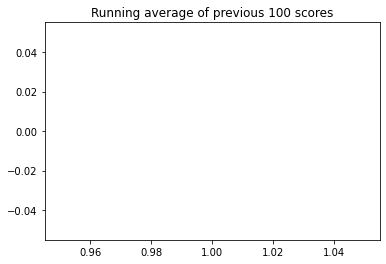

episode:  10 score 1.0 mean_score: 1.00 time_steps 726 learning_steps 11
episode:  20 score 2.0 mean_score: 1.19 time_steps 1505 learning_steps 21
episode:  30 score 1.0 mean_score: 1.13 time_steps 2203 learning_steps 31
episode:  40 score 3.0 mean_score: 1.34 time_steps 3030 learning_steps 42


In [55]:
from datetime import datetime
import os

env_name = 'Breakout-v0'
dir_name = datetime.now().strftime("%Y-%m-%d_%I-%M-%S-%p") + '_' + env_name
video_dir = dir_name + '/video'

os.mkdir(dir_name)

env.close()
env = gym.make(env_name)
env = gym.wrappers.Monitor(env, video_dir, video_callable=lambda episode_id: (episode_id%video_every)==0,force=True)

# hyperparameters
T_horizon     = 128
video_every   = 100
print_every   = 10
n_games = 5000

model = PPO().to(device)

figure_file = dir_name + '/figure.png'
scores_file = dir_name + '/scores.txt'

score_history = []
marking  = []
learn_iters = 0
avg_score = 0
n_steps = 0

with open(scores_file, "w") as f:
    for n_episode in range(n_games+1):
        s = preprocess(env.reset())
        s_buffer = deque(maxlen=tau)
        s_prime_buffer = deque(maxlen=tau)
        for i in range(tau):
            s_buffer.append(np.zeros((84, 84)))
            s_prime_buffer.append(np.zeros((84, 84)))
        
        done = False
        score = 0.0
        while not done: # while episode is not over
            for t in range(T_horizon): # no. steps before update
                s_buffer.append(s)
                s_stack = np.stack([s_buffer])
                
                prob = model.pi(torch.FloatTensor(s_stack).to(device))
                m = Categorical(prob)
                a = m.sample().item()

                reward = 0
                for _ in range(4):
                    s_prime, r, done, info = env.step(a)
                    reward += r

                    # if info['ale.lives'] < 5:
                    #     done = True
                    #     break

                    if done:
                        break
                
                s_prime = preprocess(s_prime)
                s_prime_buffer.append(s_prime)

                model.put_data((deepcopy(s_buffer), 
                                a, 
                                reward, 
                                deepcopy(s_prime_buffer), 
                                prob.cpu().detach().numpy()[0][a], 
                                done))
                s = s_prime

                n_steps += 1
                score += reward

                if done:
                    break

            model.train_net()
            learn_iters += 1
        
        score_history.append(score)
        f.write(str(score) +"\n")
        avg_score = np.mean(score_history[-100:])

        # do not change lines 44-48 here, they are for marking the submission log
        marking.append(score)
        if n_episode%100 == 0:
            print("marking, episode: {}, score: {:.1f}, mean_score: {:.2f}, std_score: {:.2f}".format(
                n_episode, score, np.array(marking).mean(), np.array(marking).std()))
            marking = []

            x = [i+1 for i in range(len(score_history))]
            plot_learning_curve(x, score_history, figure_file)

        if n_episode%1000 == 0:
            pth = dir_name + '/' + 'ep=' + str(n_episode) + '_avg=' + '%.2f' % avg_score + '.pth'
            torch.save(model.state_dict(), pth)

        # you can change this part, and print any data you like (so long as it doesn't start with "marking")
        if n_episode%print_every==0 and n_episode!=0:
            print('episode: ', n_episode, 'score %.1f' % score, 'mean_score: %.2f' % avg_score,
            'time_steps', n_steps, 'learning_steps', learn_iters)

In [70]:
model = PPO().to(device)
model.load_state_dict(torch.load(pth))

<All keys matched successfully>